<h1 align="center">OpenMP part 2</h1> 

## Exercise 1:

Using your code 2D non linear convection equation from the `numba_pyccel_assignments`:
1. Parallelize the 2D non linear convection equation
2. Compare cpu time using different number of threads (Plot a figure of cpu time according to number of threads)

In [5]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D

import time
from pyccel.epyccel import epyccel
from pyccel.decorators import types

In [6]:
# %%file nonlinearconv.py
def solve_2d_nonlinearconv_pyccel(u:'float[:,:]', un:'float[:,:]', v:'float[:,:]', vn:'float[:,:]', nt:'int', dt:'float', dx:'float', dy:'float', c:'int'):
    
    ###Assign initial conditions
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    u[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    ##set hat function I.C. : v(.5<=x<=1 && .5<=y<=1 ) is 2
    v[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    row, col = u.shape
    
    
    
    #fill the update of u and v
    
    
    #$ omp parallel num_threads(32)
    #$ omp for
    for n in range(nt+1):  
        
        #$ omp for collapse(2)
        for i in range(row):
            for j in range(col):
                un[i,j] = u[i,j]
                vn[i,j] = v[i,j]
                
        u[1:,1:] = un[1:,1:] - un[1:,1:] * dt/dx * (un[1:,1:]-un[0:-1,1:])\
        -vn[1:,1:] * dt/dy * (un[1:,1:] - un[1:,0:-1])
        
        v[1:,1:] = vn[1:,1:] - un[1:,1:] * dt/dx * (vn[1:,1:] -vn[0:-1,1:])\
        -vn[1:,1:] * dt/dy * (vn[1:,1:] - vn[1:,0:-1])
        
        u[0,:] =1 
        u[-1,:] = 1
        u[:,0] = 1
        u[:,-1] = 1
        
        v[0,:] =1 
        v[-1,:] = 1
        v[:,0] = 1
        v[:,-1] = 1
        
    #$ omp end  parallel
        
    return 0

if __name__ == '__main__' :
    import numpy as np
    import time
    ###variable declarations
    nx = 101
    ny = 101
    nt = 80
    c = 1
    dx = 2 / (nx - 1)
    dy = 2 / (ny - 1)
    sigma = .2
    dt = sigma * dx

    x = np.linspace(0, 2, nx)
    y = np.linspace(0, 2, ny)

    u = np.ones((ny, nx)) ##create a 1xn vector of 1's
    v = np.ones((ny, nx))
    un = np.ones((ny, nx))
    vn = np.ones((ny, nx))  
    
    from pyccel.epyccel import epyccel
    from pyccel.stdlib.internal.openmp import omp_get_num_threads, omp_set_num_threads
    f1 = epyccel(solve_2d_nonlinearconv_pyccel , accelerators= 'openmp' )
    
    cpu_time = []
    for i in range(1,9):
        omp_set_num_threads(i)
        t1 = time.time()
        f1(u, un, v, vn, nt, dt, dx, dy, c)
        cpu_time.append(time.time()-t1)

Text(0, 0.5, 'Cpu Time')

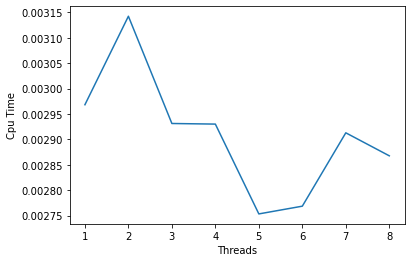

In [7]:
import matplotlib.pyplot as plt

threads = list(range(1,9))
plt.plot(threads, cpu_time)
plt.xlabel("Threads")
plt.ylabel("Cpu Time")

## Exercise 2:

Using your code Navier Stokes equation from the `numba_pyccel_assignments`:
1. Pyccelize the Navier Stokes equation (if it's not done).
2. Parallelize it using OpenMP.
3. Compare cpu time using different number of threads (Plot a figure of cpu time according to number of threads)

In [11]:
def build_up_b_cel(b:'float[:,:]', rho:'float', dt:'float', u:'float[:,:]', v:'float[:,:]', dx:'float', dy:'float'):
#     row, col = p.shape
        
    #fill the update of b
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

    return b

def pressure_poisson_cel(p:'float[:,:]', dx:'float', dy:'float', b:'float[:,:]'):
    
    row, col = p.shape
    pa = []
    for i in range(row):
        pa1 = []
        for j in range(col):
            pa1.append(0)
        pa.append(pa1)
            
    pn = np.array(pa)
    
#     pn = np.empty_like(p)
    
    for i in range(row):
            for j in range(col):
                pn[i,j] = p[i,j]
    
    #fill the update of p
    for q in range(nit):

        for i in range(row):
            for j in range(col):
                pn[i,j] = p[i,j]
                
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2
        
        
    return p

def cavity_flow_cel(nt:'int', u:'float[:,:]', v:'float[:,:]', dt:'float', nx:'int', ny:'int', dx:'float', dy:'float', p:'float[:,:]', rho:'float', nu:'float'):
    
    import numpy as np
    
    rowu, colu = u.shape
    rowv, colv = v.shape
    
    ua = []
    for i in range(rowu):
        ua1 = []
        for j in range(colu):
            ua1.append(0)
        ua.append(ua1)
            
    va = []
    for i in range(rowv):
        va1 = []
        for j in range(colv):
            va1.append(0)
        va.append(va1)
    
    ba = []
    for i in range(row):
        ba1 = []
        for j in range(col):
            ba1.append(0)
        ba.append(ba1)
        
#     ua = [[0 for i in range(rowu)] for j in range(colu)]
#     va = [[0 for i in range(rowv)] for j in range(colv)]
#     ba = [[0 for i in range(nx)] for j in range(ny)]
    
    un = np.array(ua)
    vn = np.array(va)
    b = np.array(ba)
    
    for n in range(nt):

        for i in range(rowu):
            for j in range(colu):
                un[i,j] = u[i,j]
        
        for i in range(rowv):
            for j in range(colv):
                vn[i,j] = v[i,j]
        
        from pyccel.epyccel import epyccel 
        
        bb_cel = epyccel(build_up_b_cel)
        pp_cel = epyccel(pressure_poisson_cel)
        
        b = bb_cel(b, rho, dt, u, v, dx, dy)
        p = pp_cel(p, dx, dy, b)
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))
        
        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1    # set velocity on cavity lid equal to 1
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0

    return u, v, p

In [12]:
import numpy as np
nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx)) 
b = np.zeros((ny, nx))

from pyccel.epyccel import epyccel 

cavity_flow_celf90 = epyccel(cavity_flow_cel)

# fig = pyplot.figure(figsize=(5, 3), dpi=100)
# pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
# pyplot.colorbar()
# pyplot.contour(X, Y, p, cmap=cm.viridis)
# pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
# pyplot.xlabel('X')
# pyplot.ylabel('Y');


ERROR at parsing (syntax) stage
pyccel:
 |fatal [syntax]: epyccel.py [29,11]| Pyccel has encountered syntax that has not been implemented yet. Please create an issue at https://github.com/pyccel/pyccel/issues and provide a small example of your problem. Do not forget to specify your target language (.join)



PyccelSyntaxError: Pyccel has encountered syntax that has not been implemented yet. Please create an issue at https://github.com/pyccel/pyccel/issues and provide a small example of your problem. Do not forget to specify your target language

In [ ]:
%timeit cavity_flow_celf90(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu)